## Receptive field of BlueSTARR CNN

In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt

### Algorithm for Single-Path CNNs

Receptive field calculation for a stacked CNN depends on kernel size and stride.
If a convolutional layer uses dilation, this in effect changes the kernel size, so keep track of it, too.
(Note that receptive field does not appear to depend on padding.
It also doesn't depend on the number of kernels in a layer: receptive field is defined as how many _input_ elements can contribute to one _output_ neuron.

In [2]:
convlayer = namedtuple('convlayer', ["kernelSize","dilation","stride"])

For calculation, we use the Single-Path derivation from [Araujo _et al_ (2019)](https://distill.pub/2019/computing-receptive-fields/#computing-receptive-field-size).
Specifically, we use the recursive definition in Equation (1); it is easy enough to implement in relatively simple code. In this equation, for a CNN with $L$ layers, the receptive field $r$ of layer $l-1$ is defined as follows: 
$$r_{l-1} = s_l \cdot r_l + (k_l - s_l);\;r_L = 1$$
where $k_l$ and $s_l$ are the kernel size and stride for layer $l$, respectively. To account for conv layers using dilation $\alpha$, we substitute $\alpha(k-1)+1$ for $k$. (For $\alpha=1$, i.e. no dilation, $\alpha(k-1)+1=k$.) We are interested in $r_0$, which is the receptive field for the input. (The closed form solution in Equation (2) might be faster to calculate, but the networks we are going to study here contain less than a dozen conv layers.)

In [3]:
def receptiveField(convlayers):
    l = convlayers.pop(0)
    rl = 1 if len(convlayers) == 0 else receptiveField(convlayers)
    dil = l.dilation if l.dilation else 1
    k = dil * (l.kernelSize - 1) + 1
    return l.stride * rl + (k - l.stride)

Note that this algorithm is only accurate for _Single-Path_ CNNs. The BlueSTARR convolutional module in its current configuration is a single-path CNN.

### BlueSTARR CNN receptive field for varying number of layers and dilation

In [4]:
def bluestarr(numLayers = 5,
              dilate=None, ksizes=None, kfunc=lambda i: 2**(i+3)):
    if not dilate:
        dilate = lambda i: 1
    if ksizes:
        numLayers = len(ksizes)
        kfunc = lambda i: ksizes[i]
    convs = [convlayer(kfunc(i), dilate(i), 1) for i in range(numLayers)]
    return convs

In [5]:
bluestarr()

[convlayer(kernelSize=8, dilation=1, stride=1),
 convlayer(kernelSize=16, dilation=1, stride=1),
 convlayer(kernelSize=32, dilation=1, stride=1),
 convlayer(kernelSize=64, dilation=1, stride=1),
 convlayer(kernelSize=128, dilation=1, stride=1)]

In [6]:
receptiveField(bluestarr())

244

In [7]:
receptiveField(bluestarr(dilate=lambda i: 2**i))

2698

In [8]:
bluestarr(numLayers=7)

[convlayer(kernelSize=8, dilation=1, stride=1),
 convlayer(kernelSize=16, dilation=1, stride=1),
 convlayer(kernelSize=32, dilation=1, stride=1),
 convlayer(kernelSize=64, dilation=1, stride=1),
 convlayer(kernelSize=128, dilation=1, stride=1),
 convlayer(kernelSize=256, dilation=1, stride=1),
 convlayer(kernelSize=512, dilation=1, stride=1)]

In [9]:
receptiveField(bluestarr(numLayers=7))

1010

In [14]:
def deepstarr(numLayers=4, ksizes=[7,3,5,3]):
    if len(ksizes) < numLayers:
        raise ValueError("Number of kernel sizes is fewer than number of layers")
    if len(ksizes) > numLayers:
        ksizes = ksizes[:numLayers]
    return bluestarr(ksizes=ksizes)

In [16]:
deepstarr()

[convlayer(kernelSize=7, dilation=1, stride=1),
 convlayer(kernelSize=3, dilation=1, stride=1),
 convlayer(kernelSize=5, dilation=1, stride=1),
 convlayer(kernelSize=3, dilation=1, stride=1)]

In [18]:
receptiveField(deepstarr())

15

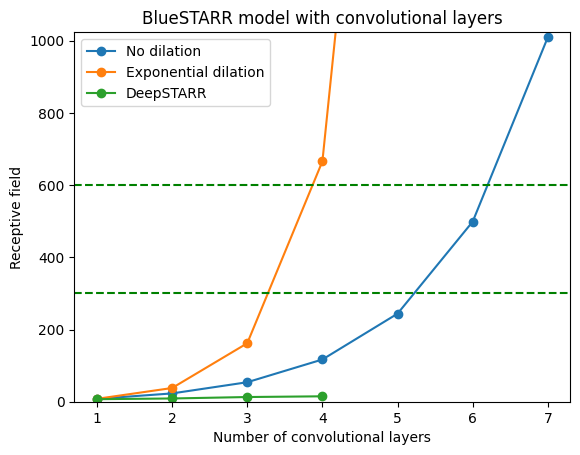

In [19]:
nlayers = [x for x in range(1, 8)]
fig, ax = plt.subplots()
lines = ax.plot(nlayers,
                [receptiveField(bluestarr(numLayers=x)) for x in nlayers],
                nlayers,
                [receptiveField(bluestarr(numLayers=x, dilate=lambda i: 2**i)) for x in nlayers],
                nlayers[:4],
                [receptiveField(deepstarr(numLayers=x)) for x in nlayers[:4]],
                marker="o")
lines[0].set_label("No dilation")
lines[1].set_label("Exponential dilation")
lines[2].set_label("DeepSTARR")
ax.set_xlabel("Number of convolutional layers")
ax.set_ylabel("Receptive field")
ax.set_title("BlueSTARR model with convolutional layers")
ax.axhline(y=300, color="green", linestyle="--")
ax.axhline(y=600, color="green", linestyle="--")
ax.set_ylim(0, 1024)
ax.legend()

### BPnet comparison

We use BPnet as defined in Avsec _et al_ (2021) [Base-resolution models of transcription-factor binding reveal soft motif syntax](https://doi.org/10.1038/s41588-021-00782-6). Nat Genet 53, 354–366 (2021). Specifically, kernel sizes, strides, and dilations are taken from page 29 in [Supplementary Materials](https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-021-00782-6/MediaObjects/41588_2021_782_MOESM1_ESM.pdf).

Note that BPnet in the cited implementation is _not_ a single-path CNN (due to the residual add). Hence, the calculated receptive fields are lower bounds; the actual receptive field should be higher except for the first layer (which does not use residual add).

In [11]:
def bpnet(numLayers = 10):
    ksizes = [3 for i in range(numLayers-1)]
    ksizes.insert(0, 25)
    convs = [convlayer(k, 2**i, 1) for i, k in enumerate(ksizes)]
    return convs

In [12]:
bpnet()

[convlayer(kernelSize=25, dilation=1, stride=1),
 convlayer(kernelSize=3, dilation=2, stride=1),
 convlayer(kernelSize=3, dilation=4, stride=1),
 convlayer(kernelSize=3, dilation=8, stride=1),
 convlayer(kernelSize=3, dilation=16, stride=1),
 convlayer(kernelSize=3, dilation=32, stride=1),
 convlayer(kernelSize=3, dilation=64, stride=1),
 convlayer(kernelSize=3, dilation=128, stride=1),
 convlayer(kernelSize=3, dilation=256, stride=1),
 convlayer(kernelSize=3, dilation=512, stride=1)]

In [13]:
receptiveField(bpnet())

2069

A $r_0$ of 2069 for a 10-layer conv module matches what is given in [Fig 1(g)](https://www.nature.com/articles/s41588-021-00782-6/figures/1) in Avsec _et al_ (2021), suggesting that their receptive field calculation assumed a single-path CNN (presumably in a lower-bound calculation). Fig 1(g) suggests that the predictive accuracy drops off with $L<9$. 9 layers still achieve a receptive field > 1kb (but barely so).

In [14]:
receptiveField(bpnet(9))

1045

Text(0.5, 1.0, 'BPNet model under the assumption of single path')

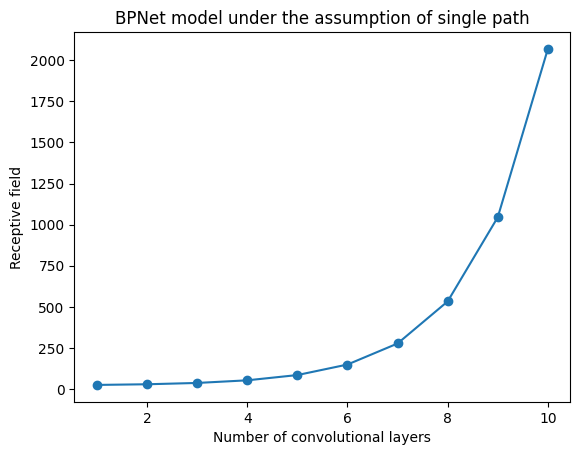

In [16]:
nlayers = [x for x in range(1, 11)]
fig, ax = plt.subplots()
lines = ax.plot(nlayers,
                [receptiveField(bpnet(numLayers=x)) for x in nlayers],
                marker="o")
ax.set_xlabel("Number of convolutional layers")
ax.set_ylabel("Receptive field")
ax.set_title("BPNet model under the assumption of single path")